## Name: Jared Egerer
## Date: 18 April 2023

### Assignment: Project 3 - Web Scraped Data Analysis

### I. Web Scraping
#### Import Statements

In [175]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import seaborn as sns
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt

**Conduct Web Scraping**  
In order to automate the web scraping, a dictionary is created to hold the type of commodity (key) and the respective URL snippet (value).

In [176]:
commodity = {'Crude, Average Spot': 'crude-oil', 'Brent': 'crude-oil-brent', 
             'Dubai': 'crude-oil-dubai', 
             'WTI': 'crude-oil-west-texas-intermediate',
             'Diesel': 'diesel', 'Gasoline': 'gasoline'}

Web scraping for the five pages listed in the dictionary is performed as follows:  
- parse the dictionary, 
- use Beautiful Soup to scrape a page, 
- create a dataframe, 
- modify the dataframe to remove the unneeded 'Change' column and add a 'Commodity' column, 
- add the dataframe to a list, and 
- move onto the next dictionary entry.

The list of dataframes is concatenated into a single dataframe, the index is reset, the old index column is removed, the Date column is converted to a date, and the Price column is converted to a float.

In [195]:
commodity_list = []
tmp = []
df = pd.DataFrame()

for key, value in commodity.items():
    url = 'https://www.indexmundi.com/commodities/?commodity=' + value + '&months=120'
    response = requests.get(url)
    status = response.status_code
    if status == 200:
        page = response.text
        soup = bs(page)
    else:
        print(f"Oops! Received status code {status} for commodity {key}")
        continue
    table_body = soup.find(class_ = 'tblData')
    table_rows = table_body.find_all('tr')
    
    temp_list = []
    
    for tr in table_rows:
        td = tr.find_all('td')
        row = [td_data.text for td_data in td]
        temp_list.append(row)
    
    temp_list = temp_list[1:]
    df_temp = pd.DataFrame(temp_list, columns = ['Date', 'Price', 'Change'])
    df_temp['Commodity'] = key
    df_temp = df_temp[['Commodity', 'Date', 'Price']]
    tmp.append(df_temp)

df = pd.concat(tmp).reset_index()
df = df[['Commodity', 'Date', 'Price']]
df['Date'] = pd.to_datetime(df['Date'])
df['Price'] = df['Price'].astype(float)
df

,Commodity,Date,Price
0,"Crude, Average Spot",2013-03-01,102.52
1,"Crude, Average Spot",2013-04-01,98.85
2,"Crude, Average Spot",2013-05-01,99.37
3,"Crude, Average Spot",2013-06-01,99.74
4,"Crude, Average Spot",2013-07-01,105.26
...,...,...,...
721,Gasoline,2022-11-01,2.85
722,Gasoline,2022-12-01,2.37
723,Gasoline,2023-01-01,2.59
724,Gasoline,2023-02-01,2.53


### II. Analysis

**1. Over the ten year period from March 2013 through March 2023 (121 months), how have the prices of crude oil (in dollars per barrel) from the different oil regions--Brent, Dubai, and West Texas Intermediate--compared with each other?**  

Text(0.5, 1.0, 'The prices (\\$/bbl) of the three types of crude oil have been consistenly comparable over the last 10 years.\nBrent is normally the priced highest while WTI is priced lowest.')

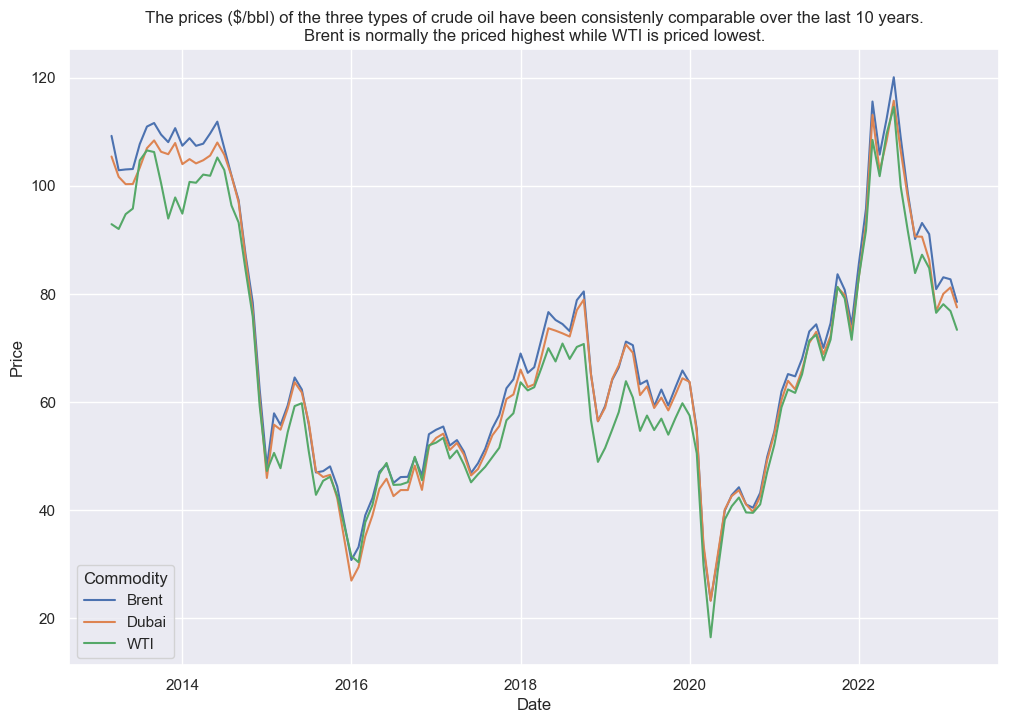

In [178]:
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize = (12, 8))
sns.lineplot(x = "Date", 
             y = "Price", 
             hue = "Commodity", 
             data = df[(df.Commodity == 'Brent') | (df.Commodity == 'Dubai') | (df.Commodity == 'WTI')])
plt.title('The prices (\$/bbl) of the three types of crude oil have been consistenly comparable over the last 10 years.\nBrent is normally the priced highest while WTI is priced lowest.')

From the graph above, Brent crude oil is consistently priced higher than Dubai and WTI, and WTI is generally lower than Dubai, with several exceptions.

**2. Are crude oil prices affected by seasonality?  Are these seasonal trends consistent from year to year?**

Subset dataframe to only 'Crude, Average Spot' and add seasons.

In [179]:
df_avg_crude = df[df['Commodity'] == 'Crude, Average Spot'].copy()

Summarize data as a pivot table using the year as the rows and the quarter as the columns.

In [180]:
pd.options.display.float_format = '{:.2f}'.format
pd.pivot_table(df_avg_crude, values = 'Price', 
               index = df_avg_crude['Date'].dt.year, columns = df_avg_crude['Date'].dt.quarter).fillna('-')


Date,1,2,3,4
Date,,,,
2013,102.52,99.32,107.39,104.51
2014,103.66,106.32,100.38,74.59
2015,51.58,60.45,48.77,42.21
2016,32.72,44.79,44.68,49.06
2017,52.95,49.41,50.18,58.68
2018,64.62,71.40,73.04,64.34
2019,60.50,65.06,59.73,60.34
2020,49.06,30.29,42.04,43.64
2021,59.30,67.05,71.65,78.28


From this table, it does not appear that prices are affected by seasonality.  Prices do not consistently increase or decrease from one quarter to the next at the same time from year to year.  For instance, from Q1 to Q2 in 2013, 2017, and 2020, prices decreased; however, Q1 to Q2 prices increased in all other years between 2013 and 2022.

**3. Do diesel and gasoline prices follow the same trend?  Are there points over the last 10 years where there is a significant difference?**  

In [181]:
df_gas_diesel = df[(df['Commodity'] == 'Gasoline') | (df['Commodity'] == 'Diesel')].reset_index()
df_gas_diesel = df_gas_diesel[['Commodity', 'Date', 'Price']]
df_gas_diesel

,Commodity,Date,Price
0,Diesel,2013-03-01,3.04
1,Diesel,2013-04-01,2.90
2,Diesel,2013-05-01,2.89
3,Diesel,2013-06-01,2.89
4,Diesel,2013-07-01,3.02
...,...,...,...
237,Gasoline,2022-11-01,2.85
238,Gasoline,2022-12-01,2.37
239,Gasoline,2023-01-01,2.59
240,Gasoline,2023-02-01,2.53


In [182]:
gas_diesel_pivot = pd.pivot_table(df_gas_diesel, values = 'Price', 
               index = 'Date', columns = 'Commodity')
gas_diesel_pivot

Commodity,Diesel,Gasoline
Date,,
2013-03-01,3.04,2.91
2013-04-01,2.90,2.71
2013-05-01,2.89,2.74
2013-06-01,2.89,2.74
2013-07-01,3.02,2.92
...,...,...
2022-11-01,4.06,2.85
2022-12-01,3.12,2.37
2023-01-01,3.27,2.59


In [183]:
gas_diesel_pivot['Difference'] = gas_diesel_pivot['Diesel'] - gas_diesel_pivot['Gasoline']
gas_diesel_pivot

Commodity,Diesel,Gasoline,Difference
Date,,,
2013-03-01,3.04,2.91,0.13
2013-04-01,2.90,2.71,0.19
2013-05-01,2.89,2.74,0.15
2013-06-01,2.89,2.74,0.15
2013-07-01,3.02,2.92,0.10
...,...,...,...
2022-11-01,4.06,2.85,1.21
2022-12-01,3.12,2.37,0.75
2023-01-01,3.27,2.59,0.68


In [184]:
diff_max = round(gas_diesel_pivot['Difference'].max(axis=0), 2)
diff_min = round(gas_diesel_pivot['Difference'].min(axis=0), 2)

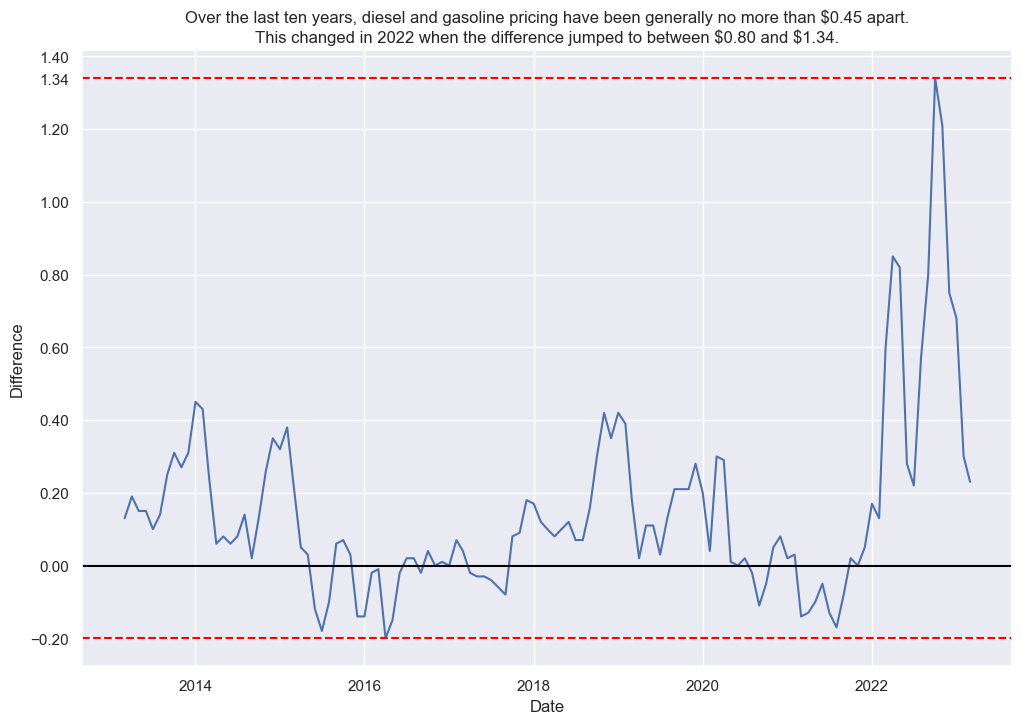

In [185]:
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize = (12, 8))
diff_plot = sns.lineplot(x = "Date", 
             y = "Difference", 
             data = gas_diesel_pivot)
plt.title('Over the last ten years, diesel and gasoline pricing have been generally no more than $0.45 apart.\nThis changed in 2022 when the difference jumped to between \$0.80 and \$1.34.')
diff_plot.set_yticks([-0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.34, 1.4])
diff_plot.axhline(diff_max, ls = '--', c = 'red')
diff_plot.axhline(diff_min, ls = '--', c = 'red')
diff_plot.axhline(0, c = 'black')

**4. Since crude oil is a major input in the production of gasoline, it would be expected that pricing for the two would trend similarly.  Are there points in time where this trend deviates?** 

Create a dataframe consisting of only Crude and Gasoline and convert it to a pivot table.

In [186]:
df_crude_gas = df[(df['Commodity'] == 'Crude, Average Spot') | (df['Commodity'] == 'Gasoline')].reset_index() 
df_crude_gas = df_crude_gas[['Commodity', 'Date', 'Price']]
df_crude_gas

,Commodity,Date,Price
0,"Crude, Average Spot",2013-03-01,102.52
1,"Crude, Average Spot",2013-04-01,98.85
2,"Crude, Average Spot",2013-05-01,99.37
3,"Crude, Average Spot",2013-06-01,99.74
4,"Crude, Average Spot",2013-07-01,105.26
...,...,...,...
237,Gasoline,2022-11-01,2.85
238,Gasoline,2022-12-01,2.37
239,Gasoline,2023-01-01,2.59
240,Gasoline,2023-02-01,2.53


In [187]:
crude_gas_pivot = pd.pivot_table(df_crude_gas, values = 'Price', 
               index = 'Date', columns = 'Commodity')
crude_gas_pivot

Commodity,"Crude, Average Spot",Gasoline
Date,,
2013-03-01,102.52,2.91
2013-04-01,98.85,2.71
2013-05-01,99.37,2.74
2013-06-01,99.74,2.74
2013-07-01,105.26,2.92
...,...,...
2022-11-01,87.38,2.85
2022-12-01,78.07,2.37
2023-01-01,80.41,2.59


Because Crude is measured in dollars per barrel and Gasoline is measured in dollars per gallon, the best way to perform this comparison would be to see the percent change from month to month.  Pandas has a built in pct_change() function.  The March 2013 percent change is undefined since it has no value for the preceding month on which to calculate.

In [188]:
c_g_pvt_change = crude_gas_pivot.pct_change().reset_index()
c_g_pvt_change['Crude, Average Spot'] = c_g_pvt_change['Crude, Average Spot'] * 100
c_g_pvt_change['Gasoline'] = c_g_pvt_change['Gasoline'] * 100
c_g_pvt_change

Commodity,Date,"Crude, Average Spot",Gasoline
0,2013-03-01,NaN,NaN
1,2013-04-01,-3.58,-6.87
2,2013-05-01,0.53,1.11
3,2013-06-01,0.37,0.00
4,2013-07-01,5.53,6.57
...,...,...,...
116,2022-11-01,-3.27,-5.32
117,2022-12-01,-10.65,-16.84
118,2023-01-01,3.00,9.28
119,2023-02-01,-0.20,-2.32


In order to plot this data, the pivot table must be melted.

In [189]:
c_g_pvt_melt = c_g_pvt_change.melt(id_vars = ['Date'], value_vars = ['Crude, Average Spot', 'Gasoline'],
                                    var_name = 'Commodity', value_name = 'Pct Change')
c_g_pvt_melt

,Date,Commodity,Pct Change
0,2013-03-01,"Crude, Average Spot",NaN
1,2013-04-01,"Crude, Average Spot",-3.58
2,2013-05-01,"Crude, Average Spot",0.53
3,2013-06-01,"Crude, Average Spot",0.37
4,2013-07-01,"Crude, Average Spot",5.53
...,...,...,...
237,2022-11-01,Gasoline,-5.32
238,2022-12-01,Gasoline,-16.84
239,2023-01-01,Gasoline,9.28
240,2023-02-01,Gasoline,-2.32


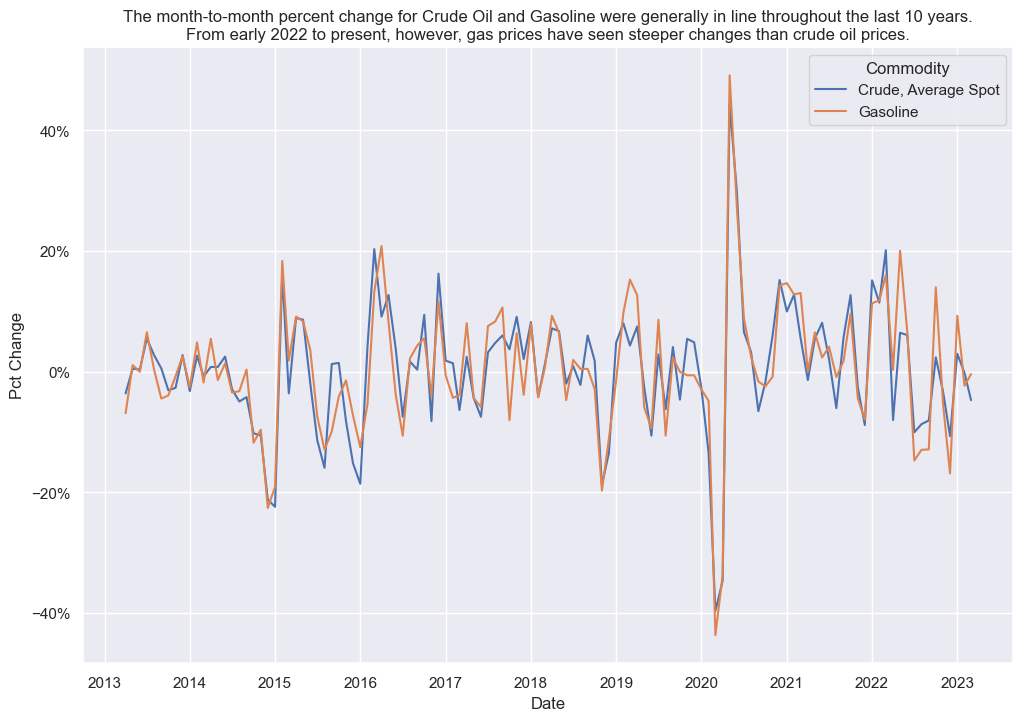

In [194]:
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize = (12, 8))
plt.title('The month-to-month percent change for Crude Oil and Gasoline were generally in line throughout the last 10 years.\nFrom early 2022 to present, however, gas prices have seen steeper changes than crude oil prices.')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
diff_plot = sns.lineplot(x = "Date", 
             y = "Pct Change", hue = 'Commodity',
             data = c_g_pvt_melt[(c_g_pvt_melt.Commodity == 'Crude, Average Spot') | (c_g_pvt_melt.Commodity == 'Gasoline')])